# Linear Regression - GMST

In [1]:
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
import cartopy.crs as ccrs

from utils import *

In [2]:
# Training sets
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
y_train = create_predictdand_data(train_files) # Already changes units of precipitation
y_train = xr.open_dataset('/glade/u/home/ianderson/train_test/y_train_outputs.nc')
X_train = xr.concat([xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_historical.nc'), xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp126.nc'),xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp370.nc'),xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp585.nc')], dim='time')

X_train = X_train.rename({'time':'year'})
X_train["year"]=np.arange(1,424) 
y_train["year"]=np.arange(1,424)

In [3]:
y_train.compute()

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, year: 423)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 416 417 418 419 420 421 422 423
Data variables:
    tas      (year, lat, lon) float32 -0.1424 -0.1424 -0.1424 ... 11.68 11.68
    pr       (year, lat, lon) float32 0.000513 0.000513 ... 0.3538 0.3538
    huss     (year, lat, lon) float32 -1.108e-06 -1.108e-06 ... 0.001122
    hurs     (year, lat, lon) float32 0.09258 0.09261 0.09261 ... -8.373 -8.373
    rlds     (year, lat, lon) float32 0.9069 0.9063 0.9063 ... 57.51 57.51 57.51
    rsds     (year, lat, lon) float32 -1.53 -1.529 -1.529 ... -27.29 -27.29
    sfcWind  (year, lat, lon) float32 -0.03228 -0.03229 -0.03229 ... 1.168 1.168
    ps       (year, lat, lon) float32 -117.7 -117.7 -117.7 ... -330.5 -330.5
    mrsos    (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    evspsbl  (year, lat, lon) float32 -6.049e-10 -6.192e-10 ... 3.421e-06

In [4]:
# Testing sets
y_test = xr.open_dataset('/glade/u/home/ianderson/train_test/y_test_outputs.nc').compute()
X_test = xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp245.nc').compute()

X_test = X_test.rename({'time':'year'})

In [5]:
y_test

<xarray.Dataset>
Dimensions:  (year: 86, lat: 192, lon: 288)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (year, lat, lon) float32 1.339 1.339 1.339 ... 9.46 9.46 9.459
    pr       (year, lat, lon) float32 0.01312 0.01312 0.01312 ... 0.1616 0.1615
    huss     (year, lat, lon) float32 9.854e-06 9.854e-06 ... 0.0008405
    hurs     (year, lat, lon) float32 0.1634 0.1634 0.1634 ... -6.797 -6.797
    rlds     (year, lat, lon) float32 4.132 4.132 4.132 ... 43.28 43.28 43.28
    rsds     (year, lat, lon) float32 0.6355 0.6353 0.6353 ... -20.81 -20.81
    sfcWind  (year, lat, lon) float32 -0.1045 -0.1045 -0.1045 ... 0.8908 0.8907
    ps       (year, lat, lon) float32 -137.5 -137.5 -137.5 ... 15.88 15.88 15.88
    evspsbl  (year, lat, lon) float32 5.2e-10 5.217e-10 ... 1.076e-06 1.077e-06
    mrsos    (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [6]:
weights = np.cos(np.deg2rad(y_train.lat))
global_mean_temp = y_train['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()
test_inputs = y_test['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()

def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

def get_nrmse_mean(truth, pred):
    rmse = get_rmse(truth, pred)
    return rmse / (truth.weighted(weights).mean().item())

In [7]:
# Linear regression from global mean temperature

def linear_GMST(variable, want_rmse, plot):
    
    reg = LinearRegression(fit_intercept=False)
    
    var_truth = y_test[variable]
    test_inputs = y_test['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()
    
    y_inp_var = y_train[variable].stack(dim=["lat", "lon"])
    lr_var = reg.fit(global_mean_temp.to_numpy().reshape(-1, 1), y_inp_var)
    m_out_v = lr_var.predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_var = m_out_v.reshape(86, 192, 288)
        
    xr_output=xr.Dataset(coords={'year': y_test.year.values, 'lat': y_test.lat.values, 'lon': y_test.lon.values})
    xr_output[variable]=(['year', 'lat', 'lon'],  m_out_var)
        
    if want_rmse == True:
            print(f"RMSE 2080-2100: {get_rmse(var_truth[65:], m_out_var[65:]).mean()}")
            print(f"RMSE 2050-2100: {get_rmse(var_truth[35:], m_out_var[35:]).mean()}")
            print("\n")
        
            print(f"NRMSE 2080-2100: {get_nrmse_mean(var_truth[65:], m_out_var[65:]).mean()}")
            print(f"NRMSE 2050-2100: {get_nrmse_mean(var_truth[35:], m_out_var[35:]).mean()}")
            
            # if plotting below is same for mrsos, re indent to be aligned with the main if else 
    if plot == True:
        var_out = xr.DataArray(m_out_var, dims=('year', 'lat', 'lon'))
        x = range(2015,2101)
        plt.figure(figsize=(7, 7))
        plt.scatter(x, y_train[variable][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
        plt.scatter(x, y_test[variable][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
        plt.scatter(x, y_train[variable][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
        plt.scatter(x, y_train[variable][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
        plt.plot(x, var_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
        plt.title(f"Change in {variable} from baseline")
        plt.legend()

        
    return xr_output



## Plotting predicted, truth, and difference 

In [8]:
import cartopy.crs as ccrs

RMSE 2080-2100: 0.4422001519710769
RMSE 2050-2100: 0.4288755035585485


NRMSE 2080-2100: 0.13505872146999245
NRMSE 2050-2100: 0.14768949567378392


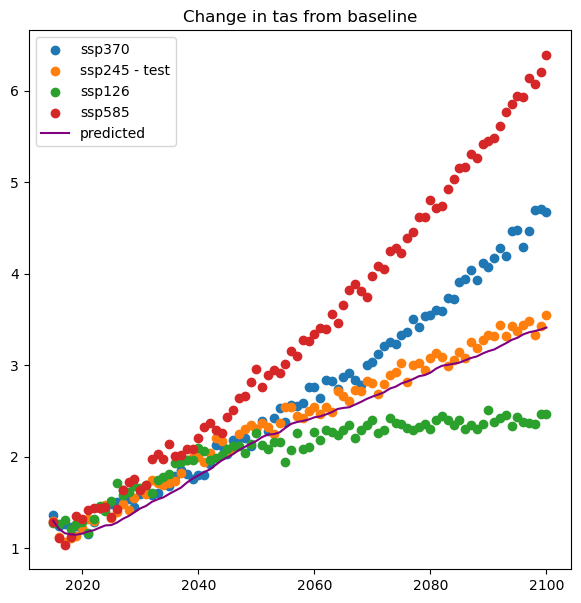

In [9]:
x = range(2015,2101)
tas_out = linear_GMST('tas', True, True)

[Text(0.5, 1.0, 'Difference')]

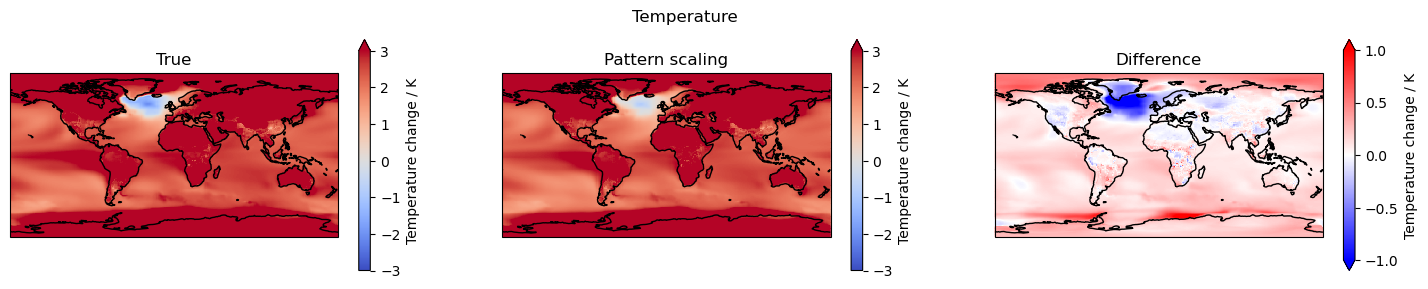

In [10]:
## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
tas_truth = y_test['tas']
plt.subplot(131, projection=proj)
tas_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
tas_out["tas"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = tas_truth - tas_out["tas"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmax=1,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [11]:
print(f"RMSE: {get_rmse(tas_truth[65:], tas_out['tas'][65:]).mean()}")
print(f"RMSE: {get_rmse(tas_truth[35:], tas_out['tas'][35:]).mean()}")

RMSE: 0.4422001519710769
RMSE: 0.4288755035585485


### `pr`

RMSE 2080-2100: 0.5682447481901001
RMSE 2050-2100: 0.5679448107748227


NRMSE 2080-2100: 3.600701549035397
NRMSE 2050-2100: 4.411118239865819


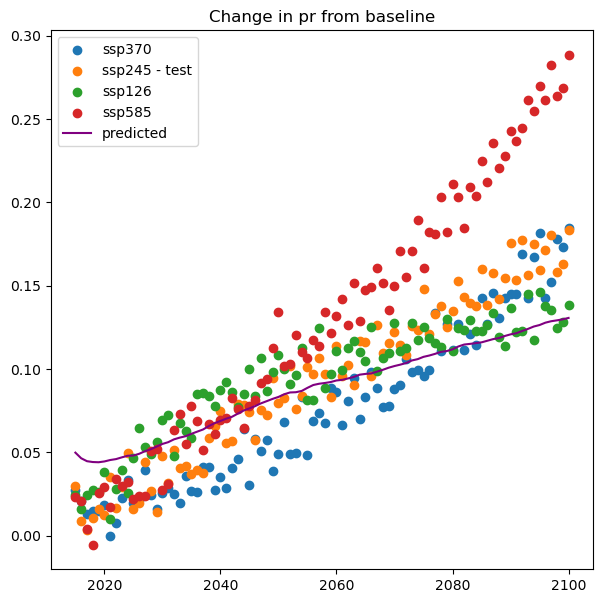

In [12]:
pr_out = linear_GMST('pr', True, True)

[Text(0.5, 1.0, 'Difference')]

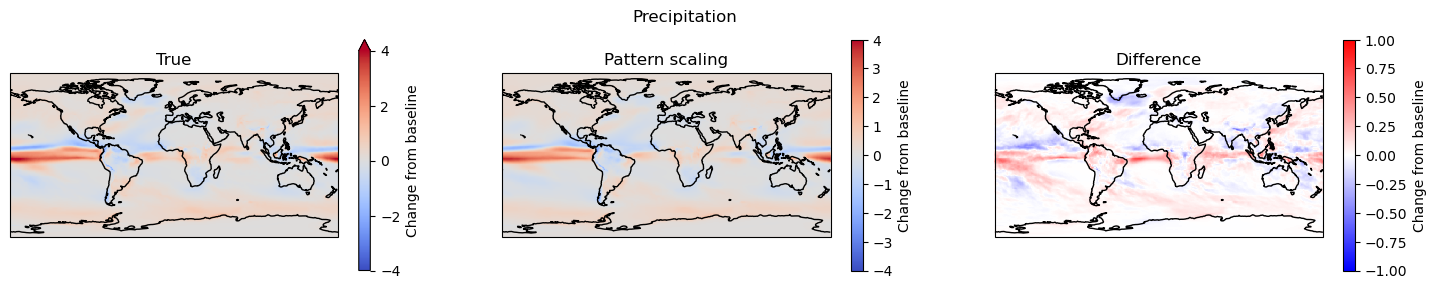

In [13]:
## Precipitation
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precipitation')

# Test
pr_truth = y_test['pr']
plt.subplot(131, projection=proj)
pr_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -4, vmax=4,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
pr_out["pr"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -4, vmax=4,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = pr_truth - pr_out["pr"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -1, vmax=1,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `huss`

RMSE 2080-2100: 0.00029183027994735054
RMSE 2050-2100: 0.00027962707604664696


NRMSE 2080-2100: 0.14479229097462115
NRMSE 2050-2100: 0.15775576164337046


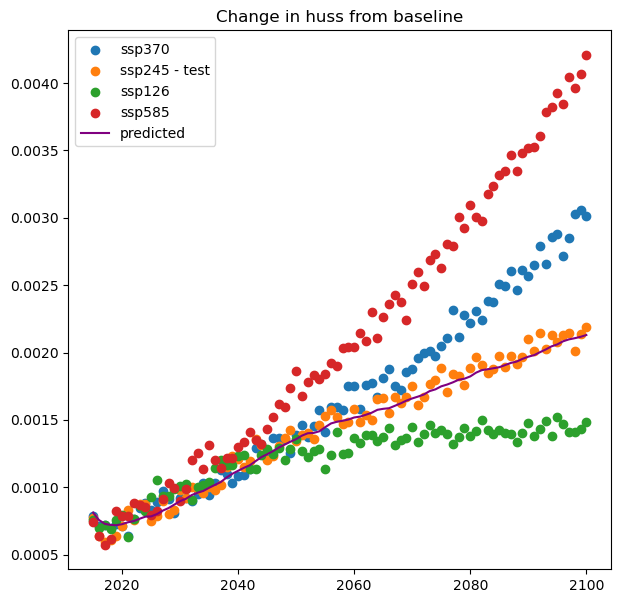

In [14]:
huss_out = linear_GMST('huss', True, True)

[Text(0.5, 1.0, 'Difference')]

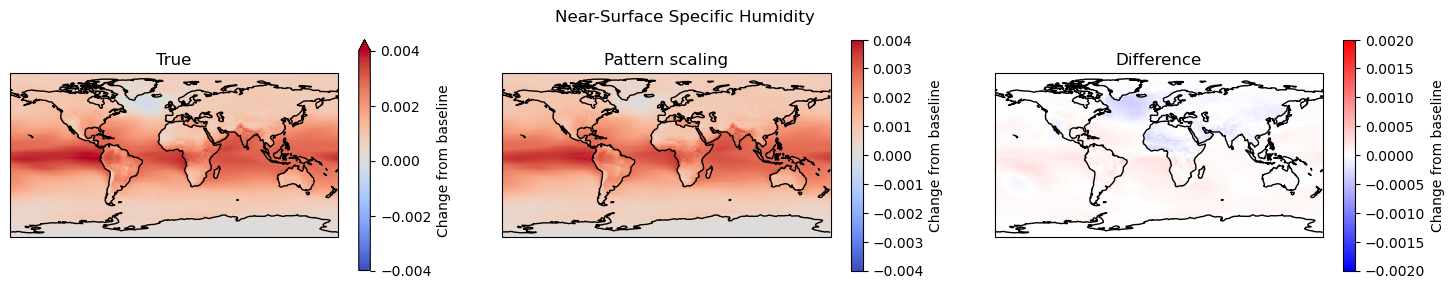

In [15]:
## Specific Humidity
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Near-Surface Specific Humidity')

# Test
huss_truth = y_test['huss']
plt.subplot(131, projection=proj)
huss_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -0.004, vmax=0.004,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
huss_out["huss"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm",vmin = -0.004, vmax=0.004,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = huss_truth - huss_out["huss"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -0.002, vmax=0.002,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `hurs`

RMSE 2080-2100: 0.9755387233511973
RMSE 2050-2100: 0.973969060154418


NRMSE 2080-2100: 65.73099420339341
NRMSE 2050-2100: 36.643461880995474


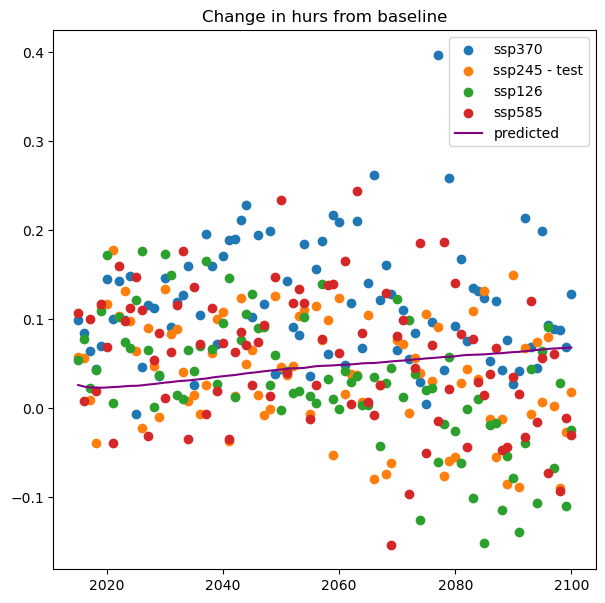

In [16]:
hurs_out = linear_GMST('hurs', True, True)

[Text(0.5, 1.0, 'Difference')]

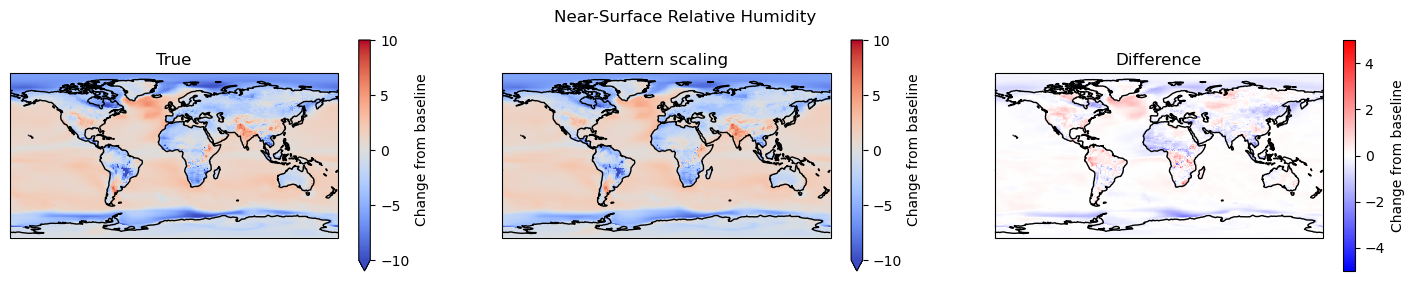

In [17]:
## Relative Humidity
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Near-Surface Relative Humidity')

# Test
hurs_truth = y_test['hurs']
plt.subplot(131, projection=proj)
hurs_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=10,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
hurs_out["hurs"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=10,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = hurs_truth - hurs_out["hurs"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr",vmin = -5, vmax=5,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `rlds`

RMSE 2080-2100: 2.735765599660099
RMSE 2050-2100: 2.6842921671650184


NRMSE 2080-2100: 0.12329840996845613
NRMSE 2050-2100: 0.13498875167180197


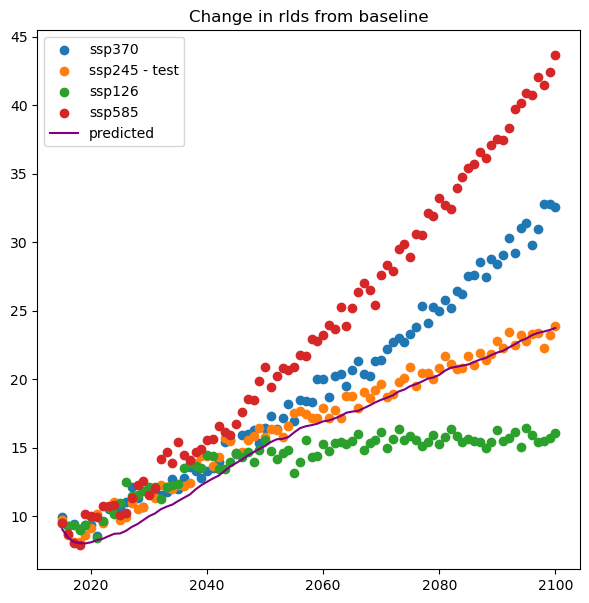

In [18]:
rlds_out = linear_GMST('rlds', True, True)

[Text(0.5, 1.0, 'Difference')]

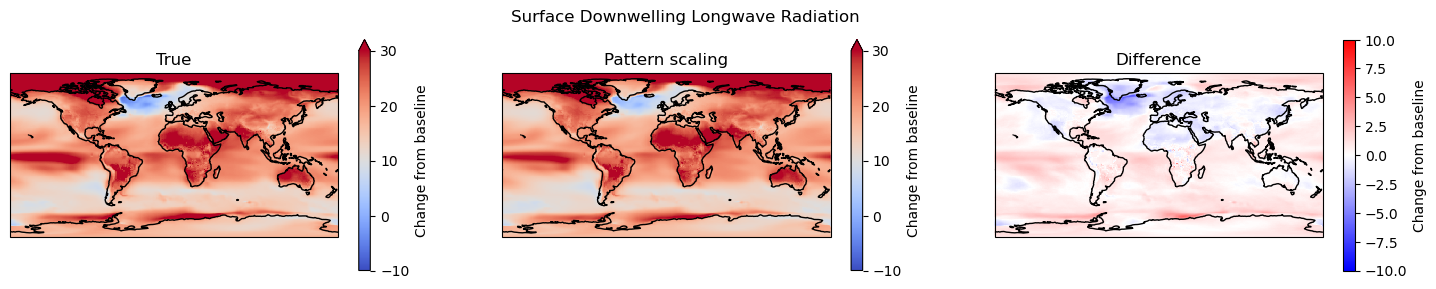

In [19]:
## Surface Downwelling Longwave Radiation
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Surface Downwelling Longwave Radiation')

# Test
rlds_truth = y_test['rlds']
plt.subplot(131, projection=proj)
rlds_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=30,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
rlds_out["rlds"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -10, vmax=30,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = rlds_truth - rlds_out["rlds"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -10, vmax=10,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `rsds`

RMSE 2080-2100: 4.845428770250838
RMSE 2050-2100: 4.625581292892572


NRMSE 2080-2100: -3.034451382206023
NRMSE 2050-2100: -2.1621209735264983


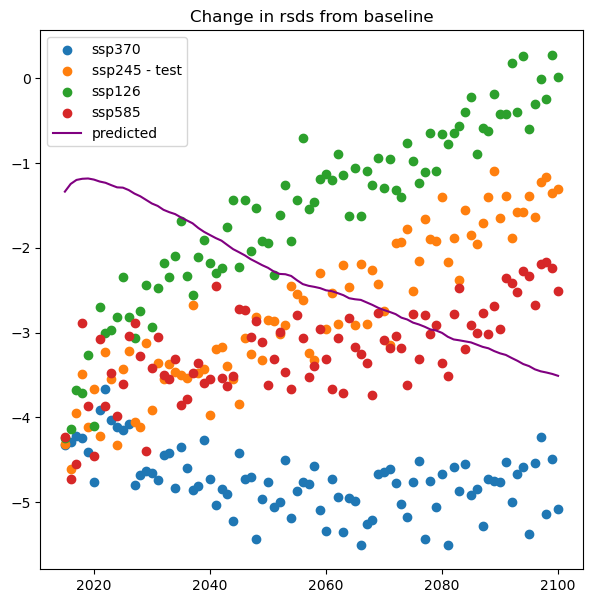

In [20]:
rsds_out = linear_GMST('rsds', True, True)

[Text(0.5, 1.0, 'Difference')]

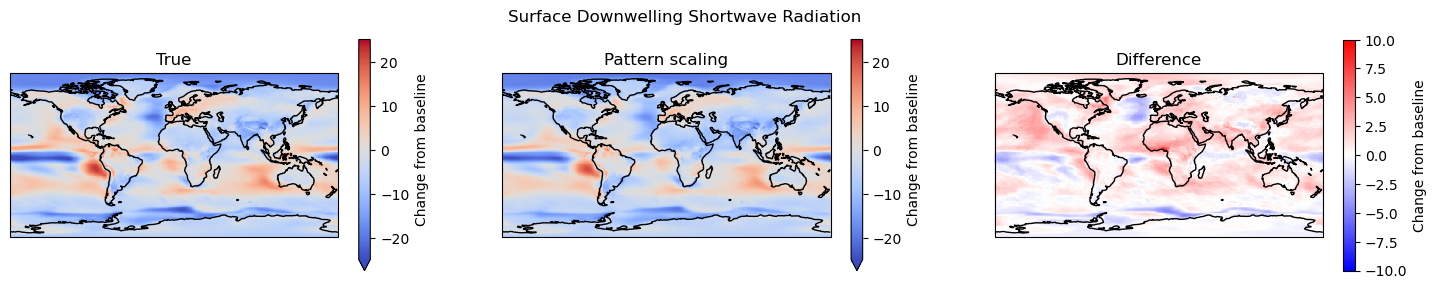

In [21]:
## Surface Downwelling Shortwave Radiation
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Surface Downwelling Shortwave Radiation')

# Test
rsds_truth = y_test['rsds']
plt.subplot(131, projection=proj)
rsds_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -25, vmax=25,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
rsds_out["rsds"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -25, vmax=25,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = rsds_truth - rsds_out["rsds"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -10, vmax=10,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `sfcWind`

RMSE 2080-2100: 0.20397864016510342
RMSE 2050-2100: 0.2057353551802699


NRMSE 2080-2100: -4.893742505715861
NRMSE 2050-2100: -5.45974337559287


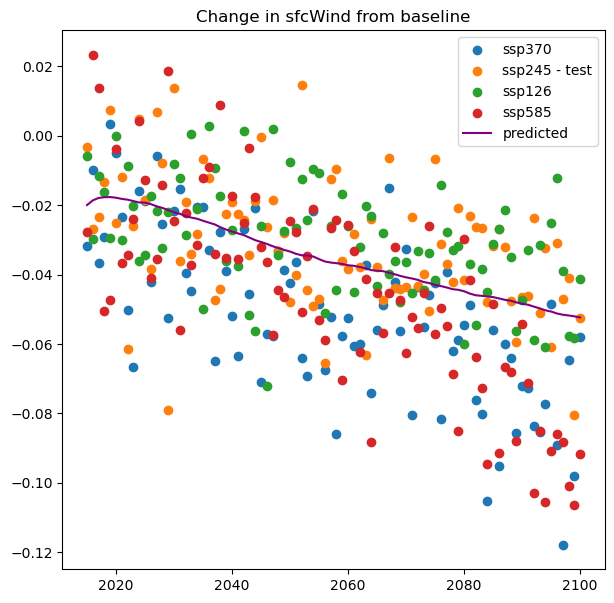

In [22]:
wind_out = linear_GMST('sfcWind', True, True)

[Text(0.5, 1.0, 'Difference')]

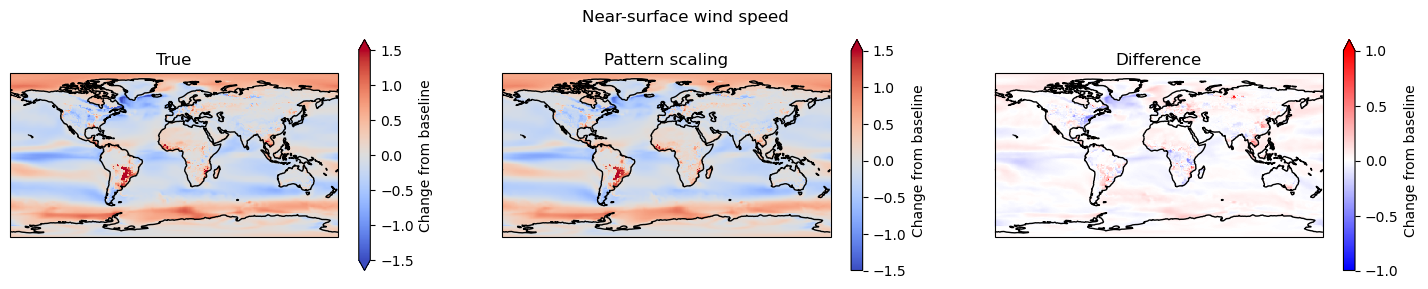

In [23]:
## Near-surface wind speed
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Near-surface wind speed')

# Test
sfcWind_truth = y_test['sfcWind']
plt.subplot(131, projection=proj)
sfcWind_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -1.5, vmax=1.5,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
wind_out["sfcWind"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -1.5, vmax=1.5,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = sfcWind_truth - wind_out["sfcWind"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -1, vmax=1,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

### `ps`

RMSE 2080-2100: 78.34655201594694
RMSE 2050-2100: 77.15593724436677


NRMSE 2080-2100: 1.3187344885549899
NRMSE 2050-2100: 1.4762065928189068


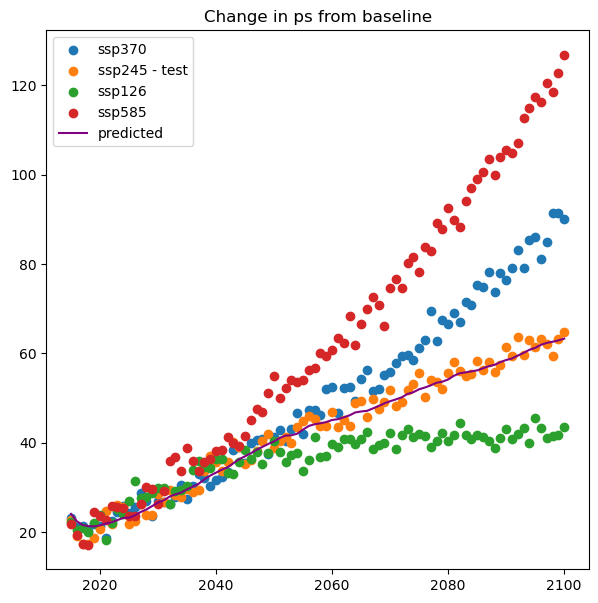

In [24]:
ps_out = linear_GMST('ps', True, True)

[Text(0.5, 1.0, 'Difference')]

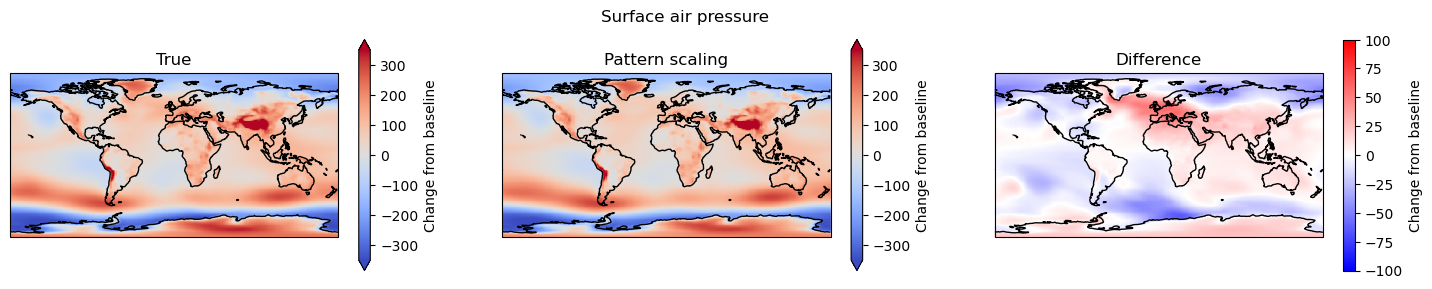

In [25]:
## Surface air pressure
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Surface air pressure')

# Test
ps_truth = y_test['ps']
plt.subplot(131, projection=proj)
ps_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm",vmin = -350, vmax=350,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
ps_out["ps"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -350, vmax=350,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = ps_truth - ps_out["ps"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -100, vmax=100,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

## `evspsbl`

RMSE 2080-2100: 1.7909393483707178e-06
RMSE 2050-2100: 1.7042568877309682e-06


NRMSE 2080-2100: 0.9798215252363612
NRMSE 2050-2100: 1.142857327943954


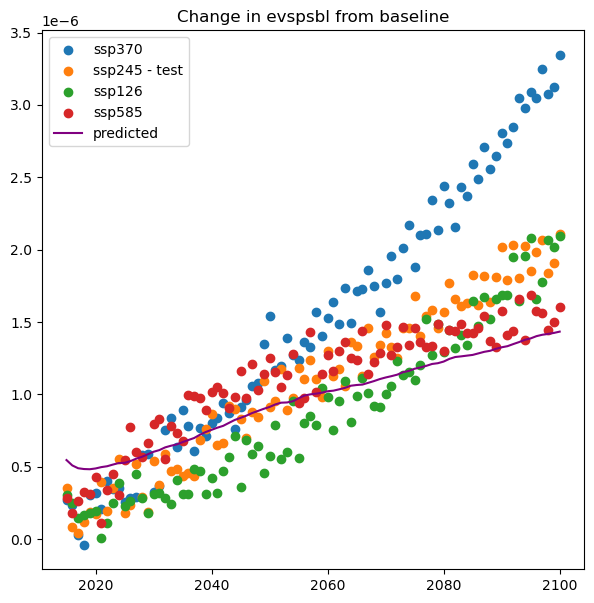

In [26]:
evspsbl_out = linear_GMST('evspsbl', True, True)

[Text(0.5, 1.0, 'Difference')]

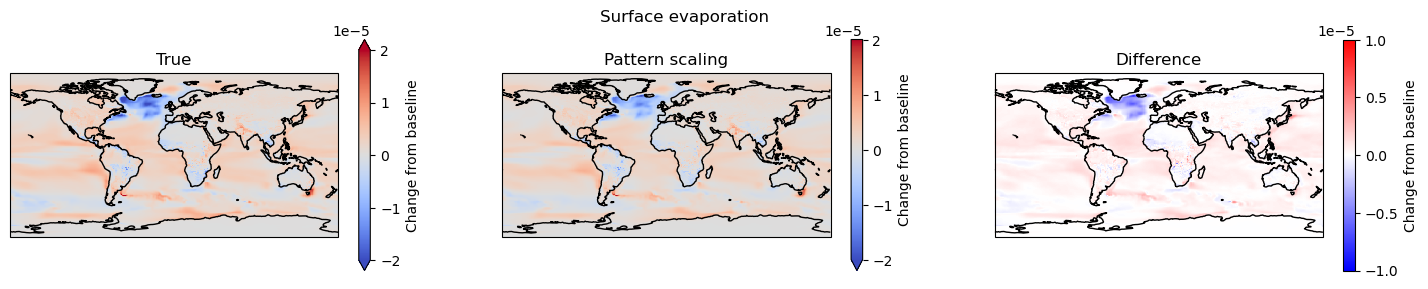

In [27]:
## Surface evaporation
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Surface evaporation')

# Test
evspsbl_truth = y_test['evspsbl']
plt.subplot(131, projection=proj)
evspsbl_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -0.00002, vmax=0.00002,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
evspsbl_out["evspsbl"].sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -0.00002, vmax=0.00002,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = evspsbl_truth - evspsbl_out["evspsbl"]
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -0.00001, vmax=0.00001,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

## `mrsos`

In [30]:
y_train_mrsos_flattened = y_train['mrsos'].stack(z=("lat", "lon")).dropna('z')
model = LinearRegression(fit_intercept=False)
lr_mrsos = model.fit(global_mean_temp.to_numpy().reshape(-1, 1), y_train_mrsos_flattened)

mrsos_truth = y_test["mrsos"]
m_out_m = lr_mrsos.predict(test_inputs.to_numpy()[:, np.newaxis])
mrsos_pred_unstacked = xr.DataArray(m_out_m, dims=("year", "z"), coords={'z': y_train_mrsos_flattened.z, "year":X_test.year})
mrsos_pred_unstacked = mrsos_pred_unstacked.unstack("z")

In [33]:
mrsos_truth = y_test['mrsos']
common_lat_values = np.intersect1d(mrsos_truth['lat'], mrsos_pred_unstacked['lat'])
mrsos_truth = mrsos_truth.sel(lat=common_lat_values)

In [34]:
print('mrsos: Land Surface Moisture')
print(f"RMSE 2080-2100: {get_rmse(mrsos_truth[65:], mrsos_pred_unstacked[65:])}")
print(f"RMSE 2050-2100: {get_rmse(mrsos_truth[35:], mrsos_pred_unstacked[35:])}")
print("\n")
print(f"NRMSE 2080-2100: {get_nrmse_mean(mrsos_truth[65:], mrsos_pred_unstacked[65:])}")
print(f"NRMSE 2050-2100: {get_nrmse_mean(mrsos_truth[35:], mrsos_pred_unstacked[35:])}")
print("\n")

mrsos: Land Surface Moisture
RMSE 2080-2100: 1.9706331072559635
RMSE 2050-2100: 1.953443784233034


NRMSE 2080-2100: -1.7008327424383525
NRMSE 2050-2100: -1.888669096945804




[Text(0.5, 1.0, 'Difference')]

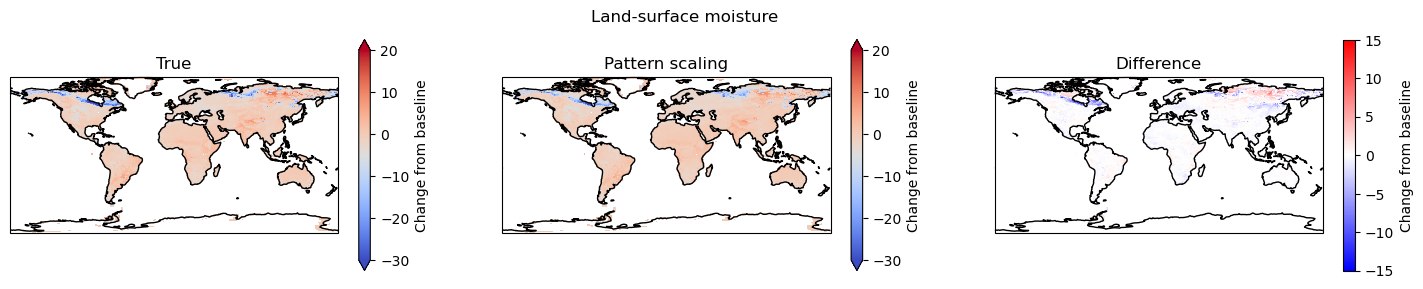

In [36]:
## land surface moisture
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Land-surface moisture')

# Test
plt.subplot(131, projection=proj)
mrsos_truth.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm",vmin = -30, vmax=20,
                              cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mrsos_pred_unstacked.sel(year=slice(2050,None)).mean('year').plot(cmap="coolwarm", vmin = -30, vmax=20,
                       cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = mrsos_truth - mrsos_pred_unstacked
plt.subplot(133, projection=proj)
difference.sel(year=slice(2050,None)).mean('year').plot(cmap="bwr", vmin = -15, vmax=15,
                cbar_kwargs={"label":"Change from baseline"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

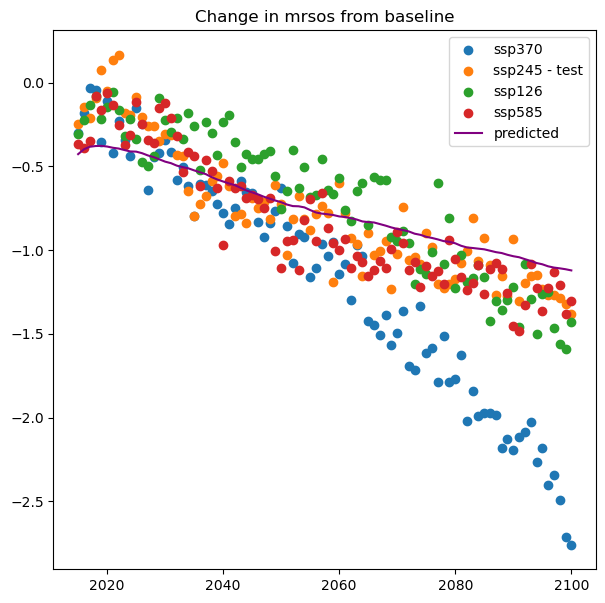

In [37]:
x = range(2015,2101)
plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['mrsos'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_test['mrsos'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['mrsos'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_train['mrsos'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, mrsos_pred_unstacked.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title(f"Change in mrsos from baseline")
plt.legend()